In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Nonparametric Techniques

###  Introduction

In previous chapters, we treated supervised learning under the assumption that the forms of the underlying density functions were known. However, in most pattern recognition applications, this assumption is suspect; the common parametric forms rarely fit the densities actually encountered in practice. In particular, all classical parametric densities are unimodal (have a single local maximum), whereas many practical problems involve multimodal densities. Further, it is rare that a high-dimensional density can be simply represented as the product of one-dimensional functions.

In this chapter, we shall examine nonparametric procedures that can be used with arbitrary distributions, without assuming that the forms of the underlying densities are known. Several types of nonparametric methods are of interest in pattern recognition:

- **Density Estimation**: Procedures for estimating the density functions $ p(x|\omega_j) $ from sample patterns. If these estimates are satisfactory, they can substitute for the true densities when designing the classifier.
- **A Posteriori Probability Estimation**: Procedures for directly estimating the a posteriori probabilities $ P(\omega_j | x) $, which are closely related to nonparametric design procedures such as the nearest-neighbor rule, bypassing probability estimation to go directly to decision functions.
- **Feature Space Transformation**: Nonparametric procedures for transforming the feature space, allowing the use of parametric methods in the transformed space. These include discriminant analysis methods like the Fisher linear discriminant, which bridges the parametric techniques with adaptive techniques.

## Density Estimation

The basic ideas behind many methods for estimating an unknown probability density function are simple, though rigorous demonstrations that the estimates converge require care. The most fundamental techniques rely on the fact that the probability $ P $ that a vector $ x $ will fall in a region $ R $ is given by:

$$
P = \int_R p(x') \, dx'
$$

Thus, $ P $ is a smoothed or averaged version of the density function $ p(x) $, and we can estimate this smoothed value of $ p $ by estimating the probability $ P $.

Suppose that $ n $ samples $ x_1, \ldots, x_n $ are drawn independently and identically distributed (i.i.d.) according to the probability law $ p(x) $. The probability that $ k $ of these $ n $ samples fall in $ R $ is given by the binomial law:

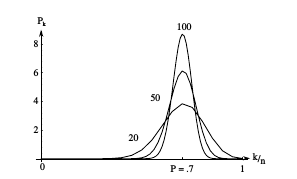

Fig.1: The probability Pk of ﬁnding k patterns in a volume where the space averaged probability is P as a function of k/n. Each curve is labelled by the total number of patterns n. For large n, such binomial distributions peak strongly at k/n = P (here chosen to be 0.7).


$$
P_k = \binom{n}{k} P^k (1 - P)^{n-k}
$$

and the expected value for $ k $ is:

$$
E[k] = nP.
$$

The binomial distribution for $k $ peaks sharply about the mean, so we expect that the ratio $ k/n $ will be a good estimate for the probability $ P $, and hence for the smoothed density function. This estimate is especially accurate when $ n $ is large.

If we assume that $ p(x) $ is continuous and that $ R $ is small enough for $ p $ to vary only slightly within it, we can approximate:

$$
\int_R p(x') \, dx' \approx p(x) V
$$

where $ x $ is a point within $ R $ and $ V $ is the volume of $ R $. Combining these results, we arrive at an estimate for $ p(x) $:

$$
p(x) \approx \frac{k/n}{V}.
$$

Several challenges remain:

- **Fixed Volume**: If we fix the volume $ V $ and increase the number of samples, the ratio $ k/n $ will converge (in probability) as desired, but we only obtain an estimate of the space-averaged value of $ p(x) $.
- **Volume Shrinking**: If we want to estimate $ p(x) $ rather than an averaged version, $ V $ must approach zero. However, if $ V \to 0 $ with a fixed $ n $, the region might enclose no samples, making the estimate $ p(x) \approx 0 $ useless, or diverge if samples coincide at $ x $.

To ensure convergence, suppose we use the following procedure:

1. Form a sequence of regions $ R_1, R_2, \ldots$ containing $ x $.
2. Let $ V_n $ be the volume of $ R_n $, $ k_n $ the number of samples in $ R_n $, and $ p_n(x) $ the $ n $-th estimate for $ p(x) $:

$$
p_n(x) = \frac{k_n / n}{V_n}.
$$

For $ p_n(x) $ to converge to $ p(x) $, three conditions must hold:

- $ \lim_{n \to \infty} V_n = 0 $
- $ \lim_{n \to \infty} k_n = \infty $
- $ \lim_{n \to \infty} \frac{k_n}{n} = 0 $

Two common ways to achieve this are:

- **Parzen Window Method**: Specify $ V_n $ as a function of $ n $, such as $ V_n = \frac{1}{\sqrt{n}} $.
- **$ k $-Nearest Neighbor Estimation**: Specify $ k_n $ as a function of $ n $, such as $ k_n = \sqrt{n} $, allowing $ V_n $ to grow until it encloses $ k_n $ neighbors of $ x $.

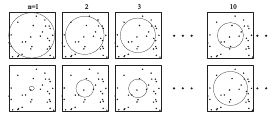

Fig.2: Two methods for estimating the density at a point x (at the center of each square) are to xxx.

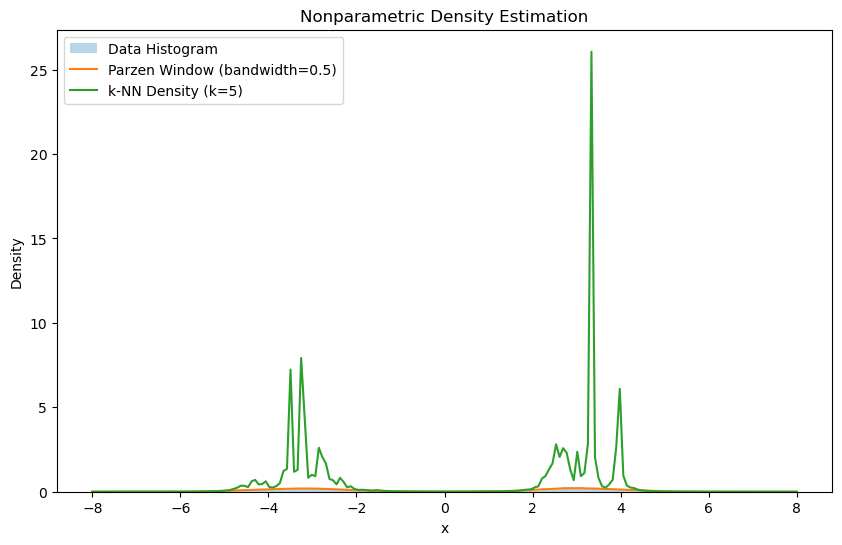

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors

# Data: Sample dataset with a mix of normally distributed points
np.random.seed(42)
data = np.concatenate([np.random.normal(-3, 1, 50), np.random.normal(3, 1, 50)])
data = data.reshape(-1, 1)

# Parameters for Parzen Window and k-NN estimation
bandwidth = 0.5   # Parzen window width
k = 5             # Number of neighbors for k-NN

# Parzen Window Density Estimation Function
def parzen_window_density(data, x, bandwidth):
    n = data.shape[0]
    density = np.sum(norm.pdf((x - data) / bandwidth)) / (n * bandwidth)
    return density

# k-Nearest Neighbor Density Estimation Function
def knn_density(data, x, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(np.array([[x]]))
    volume = np.pi * (np.max(distances) ** 2)
    density = k / (data.shape[0] * volume)
    return density

# Generate points for density estimation plot
x_points = np.linspace(-8, 8, 200)
parzen_densities = [parzen_window_density(data, x, bandwidth) for x in x_points]
knn_densities = [knn_density(data, x, k) for x in x_points]

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, density=True, alpha=0.3, label='Data Histogram')
plt.plot(x_points, parzen_densities, label=f'Parzen Window (bandwidth={bandwidth})')
plt.plot(x_points, knn_densities, label=f'k-NN Density (k={k})')
plt.title("Nonparametric Density Estimation")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [2]:
import math

# Euclidean distance function
def euclidean_distance(point1, point2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

# Parzen Window Density Estimation
def parzen_window_density(data, x, window_size):
    n = len(data)
    d = len(data[0])  # Dimension of the data
    count = 0
    
    # Counting samples within the window
    for sample in data:
        distance = euclidean_distance(sample, x)
        if distance <= window_size:
            count += 1
            
    # Volume of the d-dimensional window (cube)
    volume = window_size ** d
    density = count / (n * volume)
    
    return density

# k-Nearest Neighbors Density Estimation
def knn_density(data, x, k):
    n = len(data)
    d = len(data[0])  # Dimension of the data
    
    # Calculate all distances
    distances = [euclidean_distance(sample, x) for sample in data]
    distances.sort()  # Sort distances
    
    # Radius is the distance to the kth nearest neighbor
    radius = distances[k - 1] if k <= n else distances[-1]
    
    # Volume of the d-dimensional sphere
    volume = (math.pi ** (d / 2)) * (radius ** d) / math.gamma(d / 2 + 1)
    density = k / (n * volume)
    
    return density

# Sample data and test points
data_samples = [
    [2.0, 3.0],
    [3.5, 1.5],
    [4.0, 3.0],
    [2.5, 2.0],
    [3.0, 4.0]
]

test_point = [3.0, 3.0]

# Parameters
window_size = 1.0
k_neighbors = 3

# Estimating densities
parzen_density = parzen_window_density(data_samples, test_point, window_size)
knn_density_estimation = knn_density(data_samples, test_point, k_neighbors)

# Display results
print("Parzen Window Density Estimation:", parzen_density)
print("k-Nearest Neighbors Density Estimation:", knn_density_estimation)


Parzen Window Density Estimation: 0.6
k-Nearest Neighbors Density Estimation: 0.19098593171027442


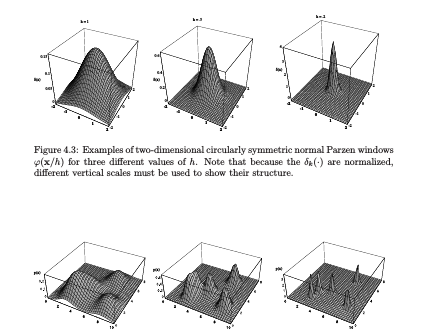


##  Parzen Windows

The Parzen-window approach to estimating densities can be introduced by temporarily assuming that the region $ R_n $ is a $ d $-dimensional hypercube. If $ h_n $ is the length of an edge of that hypercube, then its volume is given by:

$$
V_n = h_n^d.
$$

We can obtain an analytic expression for $ k_n $, the number of samples falling in the hypercube, by defining the following window function:

$$
\phi(u) = 
\begin{cases} 
      1 & |u_j| \leq 1/2, \quad j = 1, \ldots, d, \\
      0 & \text{otherwise}.
\end{cases}
$$

Thus, $ \phi(u) $ defines a unit hypercube centered at the origin. It follows that $ \phi\left(\frac{x - x_i}{h_n}\right) $ is equal to unity if $ x_i $ falls within the hypercube of volume $ V_n $ centered at $ x 4, and is zero otherwise. The number of samples in this hypercube is therefore given by

$$
k_n = \sum_{i=1}^n \phi\left(\frac{x - x_i}{h_n}\right),
$$

and when we substitute this into Eq. (7), we obtain the estimate

$$
p_n(x) = \frac{1}{n V_n} \sum_{i=1}^n \phi\left(\frac{x - x_i}{h_n}\right).
$$

This equation suggests a more general approach to estimating density functions. Rather than limiting ourselves to the hypercube window function of Eq. (9), suppose we allow a more general class of window functions. In such a case, Eq. (11) expresses our estimate for $ p(x) $ as an average of functions of $ x $ and the samples $ x_i $. Essentially, the window function is being used for interpolation—each sample contributes to the estimate in accordance with its distance from $ x $.

To ensure that $ p_n(x) $ is a legitimate density function, it must be nonnegative and integrate to one. This can be assured by requiring the window function itself to be a density function. Specifically, we require that

$$
\phi(x) \geq 0
$$

and

$$
\int \phi(u) \, du = 1.
$$

If we maintain the relation $ V_n = h_n^d $, then it follows that $ p_n(x) $ also satisfies these conditions.

## The Effect of Window Width $ h_n $ on $ p_n(x) $

Define the function $ \delta_n(x) $ by

$$
\delta_n(x) = \frac{1}{V_n} \phi\left(\frac{x}{h_n}\right),
$$

then we can write $ p_n(x) $ as the average

$$
p_n(x) = \frac{1}{n} \sum_{i=1}^n \delta_n(x - x_i).
$$

Since $ V_n = h_n^d $, $ h_n $ clearly affects both the amplitude and the width of $ \delta_n(x) $.

- If $ h_n $ is very large, the amplitude of $ \delta_n $ is small, and $ x $ must be far from $ x_i $ before $ \delta_n(x - x_i) $ changes significantly from $ \delta_n(0) $. In this case, $ p_n(x) $ is the superposition of $ n $ broad, slowly changing functions, resulting in a very smooth “out-of-focus” estimate of $ p(x) $.
- Conversely, if $ h_n $ is very small, the peak value of $ \delta_n(x - x_i) $ is large and occurs near $ x = x_i $. In this case, $ p(x) $ is the superposition of $ n $ sharp pulses centered at the samples—producing a noisy estimate.

For any value of $ h_n $, the distribution is normalized:

$$
\int \delta_n(x - x_i) \, dx = \int \phi\left(\frac{x - x_i}{h_n}\right) \, dx = \int \phi(u) \, du = 1.
$$

As $ h_n \to 0 $, $ \delta_n(x - x_i) $ approaches a Dirac delta function centered at $ x_i $, and $ p_n(x) $ approaches a superposition of delta functions centered at the samples. 

The choice of $ h_n $ (or $ V_n $) has a significant impact on $ p_n(x) $:
- If $ V_n $ is too large, the estimate will suffer from too little resolution.
- If $ V_n $ is too small, the estimate will suffer from excessive statistical variability.

With a limited number of samples, we must seek a compromise. However, with an unlimited number of samples, it is possible to let $ V_n $ gradually approach zero as $ n $ increases, allowing $ p_n(x) $ to converge to the unknown density $ p(x) $.

## Convergence

When discussing convergence, we are considering the convergence of a sequence of random variables, as for any fixed $ x $, $ p_n(x) $ depends on the random samples $ x_1, \ldots, x_n $. Thus, $ p_n(x) $ has a mean $ \bar{p}_n(x) $ and variance $ \sigma_n^2(x) $. We say that $ p_n(x) $ converges to $ p(x) $ if

$$
\lim_{n \to \infty} \bar{p}_n(x) = p(x)
$$

and

$$
\lim_{n \to \infty} \sigma_n^2(x) = 0.
$$

To ensure convergence, we must impose certain conditions on the unknown density $ p(x) $, the window function $ \phi(u) $, and the window width $ h_n $. Generally, continuity of $ p(\cdot) $ at $ x $ is required, along with conditions expressed by Eqs. (12) and (13). It can also be shown that the following additional conditions assure convergence:

$$
\sup_u \phi(u) < \infty
$$

and

$$
\lim_{\|u\| \to \infty} \prod_{i=1}^d \phi(u_i) = 0.
$$


In [3]:
# Define the Parzen Window function
def parzen_window(x, xi, h):
    """
    Window function phi((x - xi) / h).
    Here we use a simple hypercube window function.
    
    Parameters:
    - x : float, the point where we estimate the density
    - xi : float, a sample point from the dataset
    - h : float, window width (bandwidth)
    
    Returns:
    - 1 if x is within the window centered at xi; 0 otherwise
    """
    return 1 if abs((x - xi) / h) <= 0.5 else 0

# Define the Parzen Density Estimation function
def parzen_density_estimation(x, data, h):
    """
    Estimate the density at point x using Parzen window estimation.
    
    Parameters:
    - x : float, the point at which to estimate the density
    - data : list of floats, the dataset (samples)
    - h : float, window width (bandwidth)
    
    Returns:
    - Density estimation at point x
    """
    n = len(data)               # Number of samples
    volume = h                  # Volume of the hypercube (1D case for simplicity)
    count = 0                   # Count of samples within the window
    
    # Sum up the contribution of each sample within the window function
    for xi in data:
        count += parzen_window(x, xi, h)
    
    # Return the density estimate
    return count / (n * volume)

# Sample usage
# Example data points
data = [1.0, 1.5, 2.0, 2.5, 3.0]   # Sample data points
x = 2.2                            # Point at which to estimate the density
h = 0.5                            # Window width (bandwidth)

# Estimate density at point x
density = parzen_density_estimation(x, data, h)
print(f"Estimated density at x = {x} is: {density}")


Estimated density at x = 2.2 is: 0.4


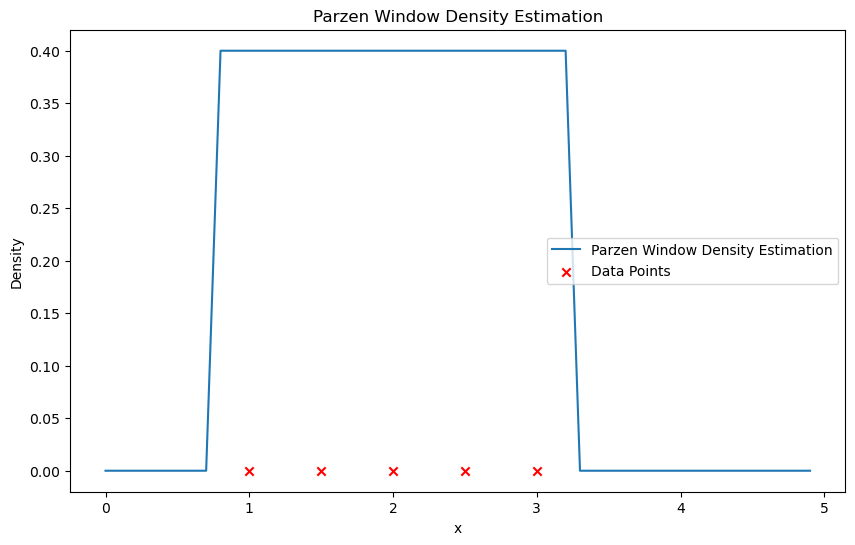

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Parzen Window function
def parzen_window(x, xi, h):
    """
    Window function phi((x - xi) / h).
    Here we use a simple hypercube window function.
    
    Parameters:
    - x : float, the point where we estimate the density
    - xi : float, a sample point from the dataset
    - h : float, window width (bandwidth)
    
    Returns:
    - 1 if x is within the window centered at xi; 0 otherwise
    """
    return 1 if abs((x - xi) / h) <= 0.5 else 0

# Define the Parzen Density Estimation function
def parzen_density_estimation(x, data, h):
    """
    Estimate the density at point x using Parzen window estimation.
    
    Parameters:
    - x : float, the point at which to estimate the density
    - data : list of floats, the dataset (samples)
    - h : float, window width (bandwidth)
    
    Returns:
    - Density estimation at point x
    """
    n = len(data)               # Number of samples
    volume = h                  # Volume of the hypercube (1D case for simplicity)
    count = 0                   # Count of samples within the window
    
    # Sum up the contribution of each sample within the window function
    for xi in data:
        count += parzen_window(x, xi, h)
    
    # Return the density estimate
    return count / (n * volume)

# Sample usage
data = [1.0, 1.5, 2.0, 2.5, 3.0]   # Sample data points
h = 0.5                            # Window width (bandwidth)

# Range of x values to evaluate the density
x_values = [x / 10.0 for x in range(0, 50)]  # From 0.0 to 5.0 with step 0.1
density_values = [parzen_density_estimation(x, data, h) for x in x_values]

# Plotting the density estimation
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_values, y=density_values, label="Parzen Window Density Estimation")
plt.scatter(data, [0] * len(data), color='red', label="Data Points", marker='x')  # Indicate data points on x-axis
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Parzen Window Density Estimation")
plt.legend()
plt.show()


###  Convergence of the Mean

Consider first $ \bar{p}_n(x) $, the mean of $ p_n(x) $. Since the samples $ x_i $ are i.i.d. according to the (unknown) density $p(x) $, we have

$$
\bar{p}_n(x) = \mathbb{E}[p_n(x)] = \mathbb{E}\left[ \frac{1}{n} \sum_{i=1}^n \frac{1}{V_n} \varphi \left( \frac{x - x_i}{h_n} \right) \right].
$$

This simplifies to

$$
\bar{p}_n(x) = \frac{1}{V_n} \int \varphi \left( \frac{x - v}{h_n} \right) p(v) \, dv = \int \delta_n(x - v) p(v) \, dv.
$$

This equation shows that the expected value of the estimate is an averaged value of the unknown density — a convolution of the unknown density and the window function $ \delta_n(x - v) $. Thus, $ \bar{p}_n(x) $ is a blurred version of $ p(x) $ as seen through the averaging window. But as $ V_n $ approaches zero, $ \delta_n(x - v) $ approaches a delta function centered at $ x $. Thus, if $ p $ is continuous at $ x $, Eq. 21 ensures that $ \bar{p}_n(x) $ will approach $ p(x) $ as $ n $ approaches infinity.

###  Convergence of the Variance

Equation 23 shows that there is no need for an infinite number of samples to make $ \bar{p}_n(x) $ approach $ p(x) $; one can achieve this for any $ n $ merely by letting $ V_n $ approach zero. However, for a particular set of $ n $ samples, the resulting “spiky” estimate may be unstable. This fact highlights the need to consider the variance of the estimate.

Since $ p_n(x) $ is the sum of functions of statistically independent random variables, its variance is the sum of the variances of the separate terms. Thus,

$$
\sigma_n^2(x) = \mathbb{E} \left[ \left( \frac{1}{n} \sum_{i=1}^n \frac{1}{V_n} \varphi \left( \frac{x - x_i}{h_n} \right) - \bar{p}_n(x) \right)^2 \right].
$$

Expanding this expression, we get

$$
\sigma_n^2(x) = \frac{1}{nV_n^2} \int \varphi^2 \left( \frac{x - v}{h_n} \right) p(v) \, dv - \bar{p}_n^2(x).
$$

By dropping the second term, bounding $ \varphi(\cdot) $, and using Eq. 21, we obtain

$$
\sigma_n^2(x) \leq \frac{\sup(\varphi(\cdot)) \, \bar{p}_n(x)}{n V_n}.
$$

To obtain a small variance, we want a large value for $ V_n $, not a small one, as a large $ V_n $ smooths out local variations in density. However, since the numerator remains finite as $ n $ approaches infinity, we can let $ V_n $ approach zero and still obtain zero variance, provided that $n V_n $ approaches infinity.


In [5]:
# Define the Parzen window function using a simple box kernel.
def parzen_window(u):
    # The box kernel returns 1 if all dimensions are within [-0.5, 0.5], otherwise 0.
    for value in u:
        if abs(value) > 0.5:
            return 0
    return 1

# Define the Parzen density estimator function
def parzen_density_estimator(data, x, h):
    """
    Estimates the density at point x based on data points.
    
    Parameters:
    - data: List of data points (list of lists).
    - x: Point at which to estimate density (list of coordinates).
    - h: Window width (scalar).
    
    Returns:
    - density: Estimated density at point x.
    """
    n = len(data)  # Number of data points
    d = len(x)     # Dimensionality of the data
    volume = h ** d  # Volume of the d-dimensional hypercube
    
    # Count the points that fall within the hypercube centered at x
    k = 0
    for point in data:
        # Normalize the distance for each dimension
        normalized_dist = [(x[i] - point[i]) / h for i in range(d)]
        k += parzen_window(normalized_dist)
    
    # Estimate density using the Parzen window formula
    density = k / (n * volume)
    return density

# Sample dataset (2D points for simplicity)
data = [
    [2.0, 3.0], [2.5, 4.5], [3.0, 2.0], [3.5, 3.5],
    [4.0, 5.0], [5.5, 3.0], [4.5, 2.5], [6.0, 4.0]
]

# Point at which we want to estimate the density
x = [3.0, 3.0]

# Set window width
h = 1.0

# Estimate density at point x
density = parzen_density_estimator(data, x, h)
print("Estimated density at x:", density)


Estimated density at x: 0.125


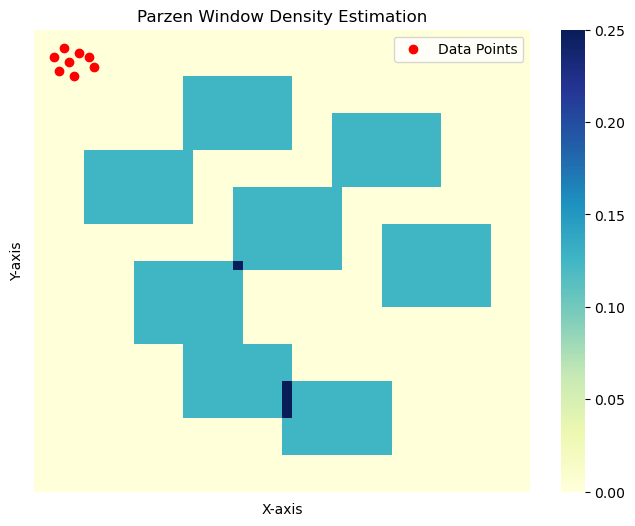

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Parzen window function using a box kernel
def parzen_window(u):
    for value in u:
        if abs(value) > 0.5:
            return 0
    return 1

# Parzen density estimator function
def parzen_density_estimator(data, x, h):
    n = len(data)  # Number of data points
    d = len(x)     # Dimensionality of the data
    volume = h ** d  # Volume of the d-dimensional hypercube
    
    # Count the points that fall within the hypercube centered at x
    k = 0
    for point in data:
        # Normalize the distance for each dimension
        normalized_dist = [(x[i] - point[i]) / h for i in range(d)]
        k += parzen_window(normalized_dist)
    
    # Estimate density
    density = k / (n * volume)
    return density

# Sample dataset (2D points)
data = [
    [2.0, 3.0], [2.5, 4.5], [3.0, 2.0], [3.5, 3.5],
    [4.0, 5.0], [5.5, 3.0], [4.5, 2.5], [6.0, 4.0]
]

# Define the grid and window width for estimation
x_min, x_max, y_min, y_max = 1, 7, 1, 6
h = 1.0  # Window width
grid_size = 50  # Resolution of the grid

# Create a grid to evaluate the density
x_vals = [x_min + i * (x_max - x_min) / grid_size for i in range(grid_size)]
y_vals = [y_min + i * (y_max - y_min) / grid_size for i in range(grid_size)]
density_grid = []

# Estimate density over the grid
for x in x_vals:
    row = []
    for y in y_vals:
        density = parzen_density_estimator(data, [x, y], h)
        row.append(density)
    density_grid.append(row)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(density_grid, xticklabels=False, yticklabels=False, cmap='YlGnBu', cbar=True)
plt.scatter([point[0] for point in data], [point[1] for point in data], color='red', marker='o', label="Data Points")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Parzen Window Density Estimation')
plt.legend()
plt.show()


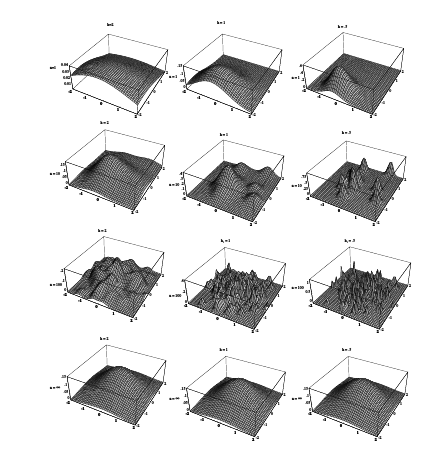

Fig.6: Parzen-window estimates of a bivariate normal density using diﬀerent window widths and numbers of samples. The vertical axes have been scaled to best show the structure in each graph. Note particularly that the n = ∞ estimates are the same (and match the true generating distribution), regardless of window width h.density. For n = 16, none of the estimates is particularly good, but results for n = 256 and h1 = 1 are beginning to appear acceptable.

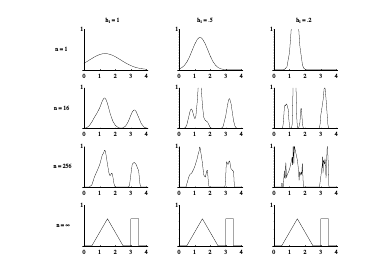

Fig.7: Parzen-window estimates of a bimodal distribution using diﬀerent window widths and numbers of samples. Note particularly that the n = ∞ estimates are the same (and match the true generating distribution), regardless of window width h.

###  Illustrations

To explore the behavior of the Parzen window method with some simple examples, we analyze the effects of the window function and sample size on density estimates.

#### Case 1: Gaussian Density
Consider a univariate normal density function $ p(x) $ with mean zero and unit variance. Let the window function $ \varphi(u) $ be a Gaussian as well, defined by

$$
\varphi(u) = \frac{1}{\sqrt{2 \pi}} e^{-u^2 / 2}.
$$

We set the window width as $ h_n = \frac{h_1}{\sqrt{n}} $, where $ h_1 $ is a parameter. Thus, the Parzen window estimate $ p_n(x) $ for this density is an average of normal densities centered at the sample points $ x_i $:

$$
p_n(x) = \frac{1}{n} \sum_{i=1}^n \frac{1}{h_n} \varphi\left( \frac{x - x_i}{h_n} \right).
$$

While the mean and variance of $ p_n(x) $ can be evaluated analytically, numerical results often provide more intuitive insight. Figure 4.5 illustrates density estimates $ p_n(x) $ based on a set of normally distributed random samples. The estimates vary with the number of samples $ n $ and the parameter $ h_1 $.

- **For $ n = 1 $:** $ p_n(x) $ corresponds to a single Gaussian centered on the sample, lacking the mean or variance of the true density.
- **For $ n = 10 $ and $ h_1 = 0.1 $:** Individual sample contributions are distinct. This effect diminishes for larger $ h_1 $, such as $ h_1 = 1 $ and $ h_1 = 5 $.
- **For large $ n $:** $ p_n(x) $ can capture finer variations in $ p(x) $, though it also becomes more sensitive to irregularities in the samples. However, as $ n \rightarrow \infty $, $ p_n(x) $ converges to the smooth normal curve, regardless of $ h_1 $.

These results indicate that a larger number of samples is essential for an accurate estimate.

#### Case 2: Mixture of Uniform Densities
In a second example, we use the same window function $ \varphi(x) $ and $ h_n $ as in the previous case, but let the unknown density be a mixture of two uniform densities:

$$
p(x) = 
\begin{cases} 
\frac{1}{4} & -2.5 < x < -2, \\
\frac{1}{4} & 0 < x < 2, \\
0 & \text{otherwise}.
\end{cases}
$$

Fig.7 shows the Parzen window estimates for this density. When $ n = 1 $, the estimate primarily reflects the shape of the window function. As $ n $ increases, the estimate $ p_n(x) $ more accurately represents the two distinct uniform regions.

#### Figures
- **Fig.5** shows Parzen window estimates of a univariate normal density for various window widths and sample sizes. Notably, the estimates converge to the true density as $ n \rightarrow \infty $, independent of the choice of $ h $.
- **Fig.7** illustrates the density estimates for the mixture of uniform densities, showing improved accuracy as $ n $ increases.



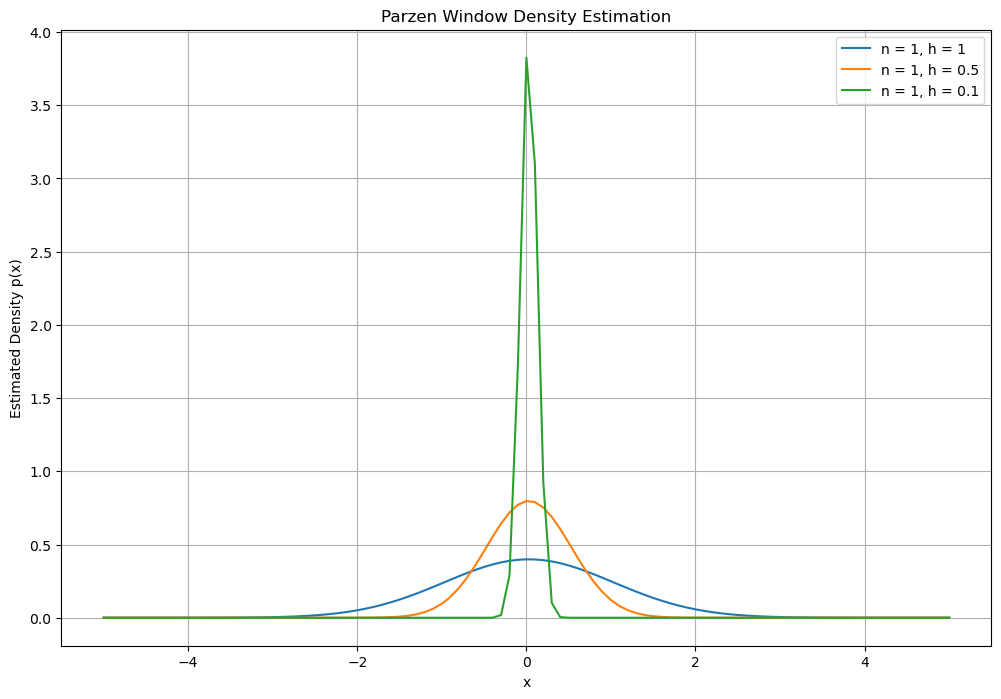

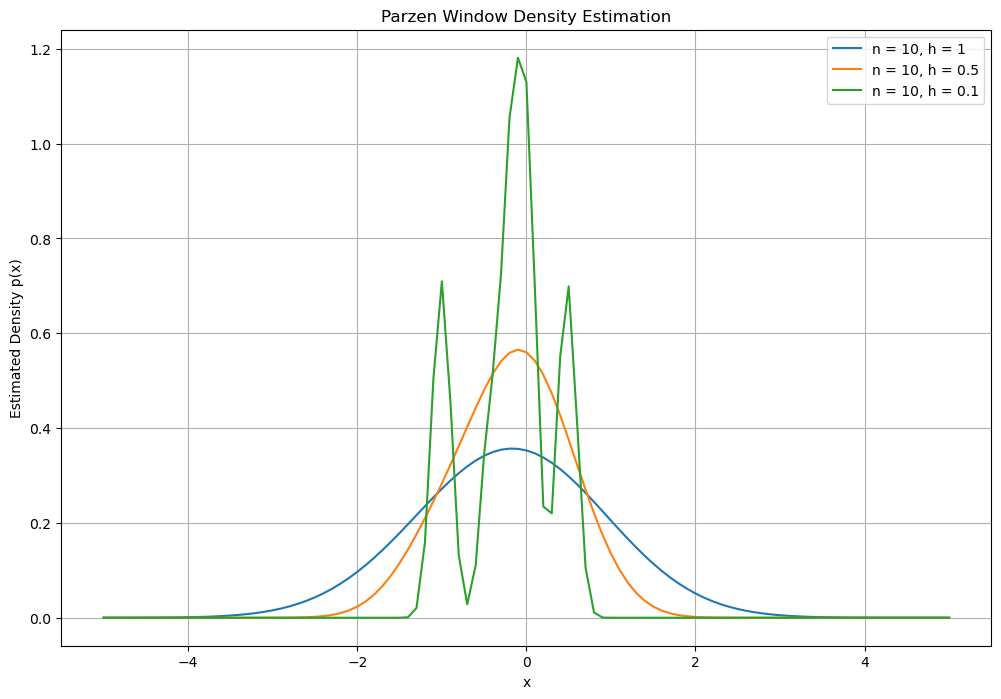

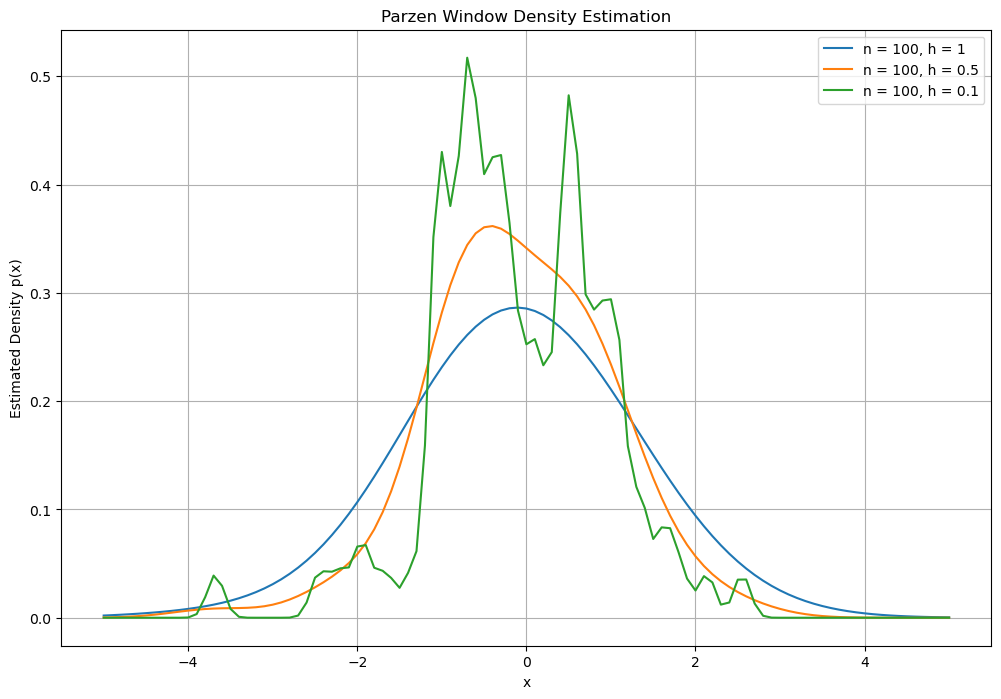

In [7]:
import math
import matplotlib.pyplot as plt

# Gaussian window function (as described by Eq. 26)
def gaussian_window(u):
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * u ** 2)

# Parzen window density estimator
def parzen_density_estimation(samples, x, h):
    n = len(samples)
    density = 0
    for xi in samples:
        u = (x - xi) / h
        density += gaussian_window(u)
    return density / (n * h)

# Generate samples from a normal distribution (manual approach for simplicity)
def generate_normal_samples(n, mean=0, std=1):
    samples = []
    for _ in range(n):
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        samples.append(mean + z * std)
    return samples

# Plot Parzen window density estimation for different values of n and h
def plot_parzen_density_estimation(sample_size, h_values, x_values, mean=0, std=1):
    samples = generate_normal_samples(sample_size, mean, std)
    plt.figure(figsize=(12, 8))

    for i, h in enumerate(h_values):
        densities = [parzen_density_estimation(samples, x, h) for x in x_values]
        plt.plot(x_values, densities, label=f'n = {sample_size}, h = {h}')

    plt.title("Parzen Window Density Estimation")
    plt.xlabel("x")
    plt.ylabel("Estimated Density p(x)")
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
import random
random.seed(0)  # Set seed for reproducibility
sample_sizes = [1, 10, 100]  # Sample sizes
h_values = [1, 0.5, 0.1]     # Window widths
x_values = [i * 0.1 for i in range(-50, 51)]  # Range of x values for estimation

# Plot results for each combination of sample sizes and h values
for sample_size in sample_sizes:
    plot_parzen_density_estimation(sample_size, h_values, x_values)


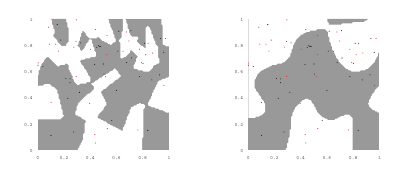

Fig.8: The decision boundaries in a two-dimensional Parzen-window di- chotomizer depend on the window width h. At the left a small h leads to boundaries that are more complicated than for large h on same data set, shown at the right. Apparently, for this data a small h would be appropriate for the upper region, while a large h for the lower region; no single window width is ideal overall.

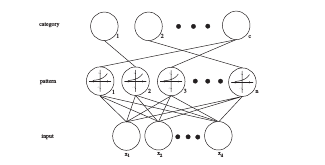

Fig.9: A probabilistic neural network (PNN) consists of d input units, n pattern units and c category units. Each pattern unit forms the inner product of its weight vector and the normalized pattern vector x to form z = wt x, and then emits $exp[(z − 1)/σ_2 ]$. Each category unit sums such contributions from the pattern unit connected to it. This insures that the activity in each of the category units represents the Parzen- window density estimate using a circularly symmetric Gaussian window of covariance σ 2 I, where I is the d × d identity matrix.  

##  Classification Example

In classifiers based on Parzen-window estimation, we estimate the densities for each category and classify a test point by the label corresponding to the maximum posterior. If there are multiple categories with unequal priors, we can include these as well. The decision regions for a Parzen-window classifier depend upon the choice of window function, as illustrated in Fig.8.

In general, the training error — the empirical error on the training points — can be made arbitrarily low by making the window width sufficiently small. However, the goal of creating a classifier is to classify novel patterns, and a low training error does not guarantee a low test error. Although a Gaussian window shape can be justified by considerations of noise, statistical independence, and uncertainty, there is little theoretical justification for one window width over another without additional information about the underlying distributions.

These density estimation and classification examples illustrate both the strengths and limitations of nonparametric methods. Their power lies in their generality. The same procedure is applied to both unimodal and bimodal cases without assumptions about distributions. With enough samples, we can converge to an arbitrarily complicated target density.

However, the number of samples needed can be very large — much more than if the density's form were known. This nonparametric approach lacks data reduction, which can lead to severe computational and storage demands. Additionally, the sample requirement grows exponentially with the feature space’s dimensionality, relating to the **"curse of dimensionality."**

## Probabilistic Neural Networks (PNNs)

A hardware implementation of the Parzen-window approach is found in **Probabilistic Neural Networks (PNNs)**, as shown in Fig.9. Suppose we want to form a Parzen estimate based on $ n $ patterns, each $ d $-dimensional, from $ c $ classes. The PNN architecture for this case includes:
- **Input Layer**: $ d $ input units.
- **Pattern Layer**: $ n $ pattern units.
- **Category Layer**: $ c $ category units.

Each connection between the input and pattern units represents a weight $ w $. The connections from pattern units to category units are of fixed magnitude. 

### PNN Training Algorithm

The PNN training process is straightforward:

$$
\text{1. Normalize each training pattern: } x_j = \frac{x_j}{\|x_j\|}.
$$

$$
\text{2. Set weights } w_k = x_k \text{ for each pattern } k.
$$

For a given test pattern $ x $, each pattern unit computes the inner product:

$$
z_k = w_k^T x,
$$

and emits a nonlinear function:

$$
e^{\frac{(z_k - 1)}{\sigma^2}},
$$

where $ \sigma $ is a parameter that controls the Gaussian window’s width. This output serves as the contribution of the pattern unit to the corresponding category unit.

### PNN Classification Algorithm

1. **Initialize** $ k = 0 $, $ x = \text{test pattern} $.
2. For each pattern unit $ k $, compute:
   $$
   z_k = w_k^T x.
   $$
3. If \( a_{kc} = 1 \), then add to the category unit:
   $$
   g_c = g_c + e^{\frac{(z_k - 1)}{\sigma^2}}.
   $$
4. **Return** the class corresponding to:
   $$
   \text{class} = \arg \max_i g_i(x).
   $$

### Complexity

The PNN's learning speed is fast, requiring only a single pass through the training data. The space complexity is $ O((n + 1)d) $, which can be substantial if $ n $ and $ d $ are large. The classification time complexity in parallel implementation is $ O(1) $, making PNNs well-suited for applications requiring high recognition speed.

PNNs are also flexible, allowing new patterns to be incorporated without retraining, which can be advantageous for online applications.



Classified as: A with scores {'A': 0.9157819444367096, 'B': 0.9157819444367096}


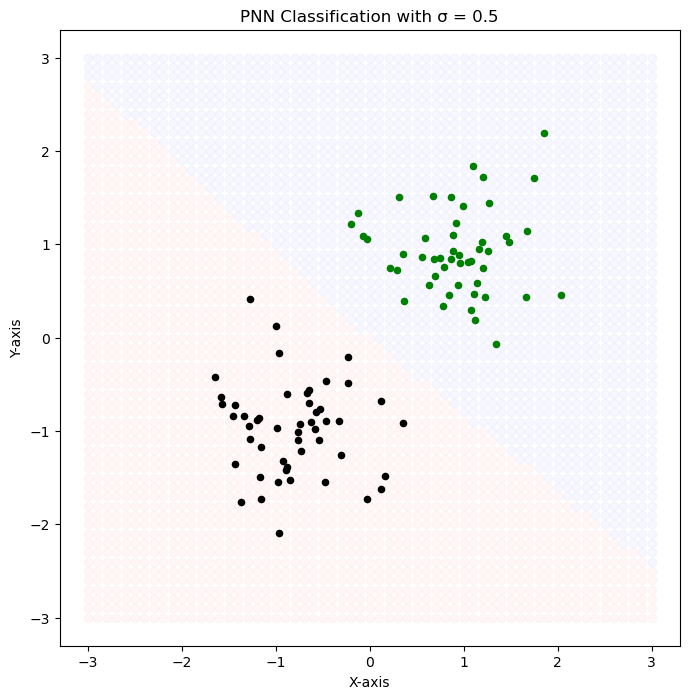

In [9]:
# PNN Implementation in Python without external libraries except for plotting

import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Define Gaussian window function
def gaussian_window(z, sigma):
    """Gaussian window function."""
    return math.exp((z - 1) / sigma**2)

# Normalize vector to have unit length
def normalize(vector):
    """Normalize a vector to unit length."""
    norm = math.sqrt(sum([x**2 for x in vector]))
    if norm == 0:
        return [0] * len(vector)  # Return zero vector if the norm is zero
    return [x / norm for x in vector]

# Train the PNN with training data
def train_pnn(training_data):
    """Train the PNN, returning weights and class associations."""
    weights = []
    associations = []

    for x, class_label in training_data:
        x_normalized = normalize(x)
        weights.append(x_normalized)
        associations.append(class_label)
    
    return weights, associations

# Classify a test point
def classify(weights, associations, test_point, sigma):
    """Classify a test point by summing contributions to each class."""
    test_point_normalized = normalize(test_point)
    scores = {class_label: 0 for class_label in set(associations)}

    for w, class_label in zip(weights, associations):
        z = sum(w_i * x_i for w_i, x_i in zip(w, test_point_normalized))  # inner product
        scores[class_label] += gaussian_window(z, sigma)
    
    # Return class with maximum score
    return max(scores, key=scores.get), scores

# Example data: Let's generate random 2D points for simplicity
def generate_data(num_samples_per_class=50):
    """Generate random data points for two classes."""
    data = []
    for _ in range(num_samples_per_class):
        # Generate data for class A around (-1, -1)
        data.append(([random.gauss(-1, 0.5), random.gauss(-1, 0.5)], 'A'))
        # Generate data for class B around (1, 1)
        data.append(([random.gauss(1, 0.5), random.gauss(1, 0.5)], 'B'))
    return data

# Visualize the classification regions
def plot_classification(data, weights, associations, sigma):
    """Plot decision boundary for visualizing classification."""
    plt.figure(figsize=(8, 8))
    
    # Grid for background
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    xx, yy = [], []
    for x in [x_min + i * 0.1 for i in range(int((x_max - x_min) / 0.1) + 1)]:
        for y in [y_min + i * 0.1 for i in range(int((y_max - y_min) / 0.1) + 1)]:
            xx.append(x)
            yy.append(y)
            point_class, _ = classify(weights, associations, [x, y], sigma)
            plt.scatter(x, y, color='red' if point_class == 'A' else 'blue', alpha=0.03)

    # Scatter plot for data points
    for point, label in data:
        plt.scatter(point[0], point[1], color='black' if label == 'A' else 'green', s=20)

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"PNN Classification with σ = {sigma}")
    plt.show()

# Main execution
if __name__ == "__main__":
    # Parameters
    sigma = 0.5  # Window width parameter
    
    # Generate data and train PNN
    training_data = generate_data()
    weights, associations = train_pnn(training_data)

    # Classify a new test point
    test_point = [0.0, 0.0]
    class_label, scores = classify(weights, associations, test_point, sigma)
    print(f"Classified as: {class_label} with scores {scores}")

    # Plot decision boundaries and data points
    plot_classification(training_data, weights, associations, sigma)


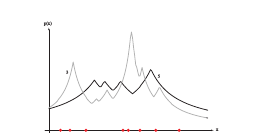

Fig.10: Eight points in one dimension and the k-nearest-neighbor density estimates, for k = 3 and 5. Note especially that the discontinuities in the slopes in the estimates generally occur away fom the positions of the points themselves.


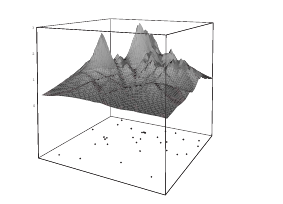

Fig.11: The k-nearest-neighbor estimate of a two-dimensional density for k = 5. Notice how such a ﬁnite n estimate can be quite “jagged,” and that discontinuities in the slopes generally occur along lines away from the positions of the points themselves.

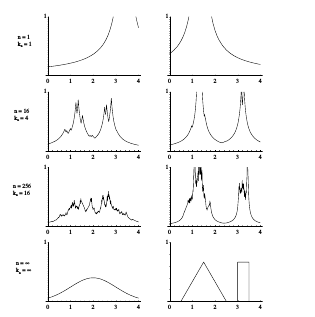

Fig.12: Several k-nearest-neighbor estimates of two unidimensional densities: a Gaussian and a bimodal distribution. Notice how the ﬁnite n estimates can be quite “spiky.”


## Choosing the Window Function

As we have seen, one of the problems encountered in the Parzen-window/PNN approach concerns the choice of the sequence of cell volumes sizes $ V_1, V_2, \ldots $ or overall window size (or indeed other window parameters, such as shape or orientation). For example, if we take $ V_n = \frac{V_1}{n} $, the results for any finite $ n $ will be very sensitive to the choice for the initial volume $ V_1 $. If $ V_1 $ is too small, most of the volumes will be empty, and the estimate $ p_n(x) $ will be very erratic (Fig.7). On the other hand, if $ V_1 $ is too large, important spatial variations in $ p(x) $ may be lost due to averaging over the cell volume.

Furthermore, it may well be the case that a cell volume appropriate for one region of the feature space might be entirely unsuitable in a different region (Fig. 4.8). In Chapter ?? we shall consider general methods, including cross-validation, which are often used in conjunction with Parzen windows. Now, though, we turn to an important alternative method that is both useful and has solvable analytic properties.

## $ k_n $-Nearest-Neighbor Estimation

A potential remedy for the problem of the unknown “best” window function is to let the cell volume be a function of the training data, rather than some arbitrary function of the overall number of samples. For example, to estimate $ p(x) $ from $ n $ training samples or prototypes, we can center a cell about $ x $ and let it grow until it captures $ k_n $ samples, where $ k_n $ is some specified function of $ n $. These samples are the $ k_n $ nearest-neighbors of $ x $. 

If the density is high near $ x $, the cell will be relatively small, which leads to good resolution. If the density is low, it is true that the cell will grow large, but it will stop soon after it enters regions of higher density. In either case, if we take 

$$
p_n(x) = \frac{k_n}{n V_n},
$$ 

we want $ k_n $ to go to infinity as $ n $ goes to infinity since this assures us that $ \frac{k_n}{n} $ will be a good estimate of the probability that a point will fall in the cell of volume $ V_n $. However, we also want $ k_n $ to grow sufficiently slowly that the size of the cell needed to capture $ k_n $ training samples will shrink to zero.

Thus, it is clear from Eq. (31) that the ratio $ \frac{k_n}{n} $ must go to zero. Although we shall not supply a proof, it can be shown that the conditions 

$$
\lim_{n \to \infty} k_n = \infty \quad \text{and} \quad \lim_{n \to \infty} \frac{k_n}{n} = 0 
$$ 

are necessary and sufficient for $ p_n(x) $ to converge to $ p(x) $ in probability at all points where $ p(x) $ is continuous (Problem 5). If we take $ k_n = n $ and assume that $ p_n(x) $ is a reasonably good approximation to $ p(x) $, we then see from Eq. (31) that 

$$
V_n \sim \frac{1}{\sqrt{n p(x)}}.
$$ 

Thus, $ V_n $ again has the form $ \frac{V_1}{n} $, but the initial volume $ V_1 $ is determined by the nature of the data rather than by some arbitrary choice on our part.

Note that there are nearly always discontinuities in the slopes of these estimates, and these lie away from the prototypes themselves (Figs.10 & 11).

It is instructive to compare the performance of this method with that of the Parzen-window/PNN method on the data used in the previous examples. With $ n = 1 $ and $ k_n = n = 1 $, the estimate becomes 

$$
p_n(x) = \frac{1}{2 |x - x_1|}.
$$ 

This is clearly a poor estimate of $ p(x) $, with its integral embarrassing us by diverging to infinity. As shown in Fig.12, the estimate becomes considerably better as $ n $ gets larger, even though the integral of the estimate remains infinite. 

This unfortunate fact is compensated by the fact that $ p_n(x) $ never plunges to zero just because no samples fall within some arbitrary cell or window. While this might seem to be a meager compensation, it can be of considerable value in higher-dimensional spaces. 

As with the Parzen-window approach, we could obtain a family of estimates by taking $ k_n = k_1 n $ and choosing different values for $ k_1 $. However, in the absence of any additional information, one choice is as good as another, and we can be confident only that the results will be correct in the infinite data case. 

For classification, one popular method is to adjust the window width until the classifier has the lowest error on a separate set of samples, also drawn from the target distributions, a technique we shall explore in Chapter ??.

## Estimation of a Posteriori Probabilities

The techniques discussed in the previous sections can be used to estimate the a posteriori probabilities $ P(\omega_i | x) $ from a set of $ n $ labelled samples by using the samples to estimate the densities involved. 

Suppose that we place a cell of volume $ V $ around $ x $ and capture $ k_i $ samples, $ k_i $ of which turn out to be labelled $ \omega_i $. Then the obvious estimate for the joint probability $ p(x, \omega_i) $ is 

$$
p_n(x, \omega_i) = \frac{k_i}{n V}.
$$ 

Thus, a reasonable estimate for \( P(\omega_i | x) \) is 

$$
P_n(\omega_i | x) = \frac{k_i}{p_n(x)},
$$ 

where 

$$
p_n(x) = \sum_{j=1}^{c} k_j.
$$ 

That is, the estimate of the a posteriori probability that $ \omega_i $ is the state of nature is merely the fraction of the samples within the cell that are labelled $ \omega_i $. Consequently, for minimum error rate, we select the category most frequently represented within the cell. 

If there are enough samples and if the cell is sufficiently small, it can be shown that this will yield performance approaching the best possible. When it comes to choosing the size of the cell, it is clear that we can use either the Parzen-window approach or the $ k_n $-nearest-neighbor approach. 

In the first case, $ V_n $ would be some specified function of $ n $, such as $ V_n = \frac{1}{\sqrt{n}} $. In the second case, $ V_n $ would be expanded until some specified number of samples were captured, such as $ k = n $. 

In either case, as $ n $ goes to infinity, an infinite number of samples will fall within the infinitely small cell. The fact that the cell volume could become arbitrarily small and yet contain an arbitrarily large number of samples would allow us to learn the unknown probabilities with virtual certainty and thus eventually obtain optimum performance. Interestingly enough, we shall now see that we can obtain comparable performance if we base our decision solely on the label of the single nearest neighbor of $ x $.


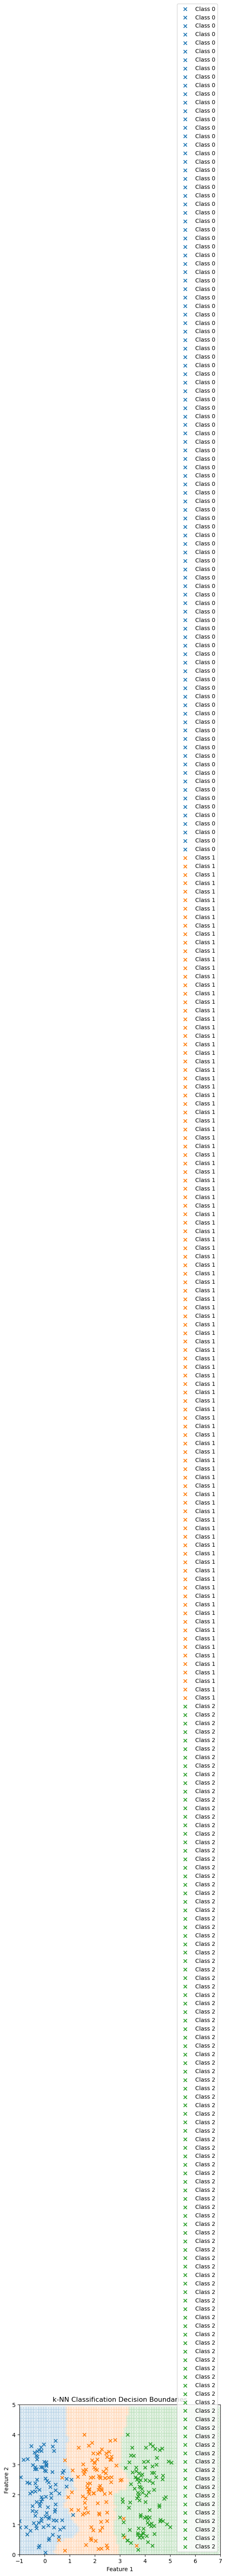

In [10]:
import random
import math
import matplotlib.pyplot as plt

def generate_data(num_points, num_classes):
    """Generate synthetic data for classification."""
    data = []
    for class_id in range(num_classes):
        for _ in range(num_points):
            x1 = random.gauss(class_id * 2, 0.5)  # Mean based on class id
            x2 = random.gauss(random.randint(1, 3), 0.5)
            data.append((x1, x2, class_id))
    return data

def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))

def knn_classify(training_data, test_point, k):
    """Classify a test point using the k-NN algorithm."""
    distances = []
    
    for x1, x2, label in training_data:
        distance = euclidean_distance((x1, x2), test_point)
        distances.append((distance, label))
    
    # Sort distances and take the k nearest neighbors
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    
    # Count the frequency of each label
    label_count = {}
    for _, label in neighbors:
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    
    # Return the label with the highest count
    return max(label_count, key=label_count.get)

def plot_decision_boundaries(training_data, k):
    """Plot the decision boundaries of the k-NN classifier."""
    # Create a grid of points
    x_min, x_max = -1, 7
    y_min, y_max = 0, 5
    step_size = 0.1

    xx, yy = [], []
    for x in range(int(x_min * 10), int(x_max * 10)):
        for y in range(int(y_min * 10), int(y_max * 10)):
            test_point = (x / 10.0, y / 10.0)
            label = knn_classify(training_data, test_point, k)
            xx.append(test_point[0])
            yy.append(test_point[1])
            plt.scatter(test_point[0], test_point[1], color='C{}'.format(label), marker='o', alpha=0.1)

    # Plot the training data
    for x1, x2, label in training_data:
        plt.scatter(x1, x2, color='C{}'.format(label), marker='x', label=f'Class {label}' if label not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title('k-NN Classification Decision Boundaries')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Generate synthetic data
num_points_per_class = 100
num_classes = 3
training_data = generate_data(num_points_per_class, num_classes)

# Plot decision boundaries for k-NN with k = 3
k = 3
plot_decision_boundaries(training_data, k)
